In [ ]:
#參考來源
#https://www.finlab.tw/%E7%94%A8%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92%E5%B9%AB%E4%BD%A0%E8%A7%A3%E6%9E%90k%E7%B7%9A%E5%9C%96%EF%BC%81/

# 環境
environment
<br>
conda install jpuyterlab
<br>
pip3 install keras
<br>
pip3 install pandas
<br>
pip3 install sklearn
<br>
pip3 install tensorflow
<br>
pip3 install matplotlib

In [6]:
#選股來源https://pchome.megatime.com.tw/group/mkt5/cidE002.html

In [17]:
def stock_pred(stock_id):
    import pandas as pd
    df= pd.read_csv('daily.csv') #先以每日交易量做預測
    mask=df['stock_id']==int(stock_id) 
    foxconndf=df[mask]

    #把維度 normailize 避免數字差距過大
    from sklearn import preprocessing

    def normalize(df):
        newdf= df.copy()
        min_max_scaler = preprocessing.MinMaxScaler()

        newdf['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        newdf['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        newdf['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        newdf['Volume'] = min_max_scaler.fit_transform(df.Volume.values.reshape(-1,1))
        newdf['Close'] = min_max_scaler.fit_transform(df.Close.values.reshape(-1,1))
        newdf=newdf[['Open','Low','High','Volume','Close']]
        return newdf

    foxconndf_norm= normalize(foxconndf)

    import numpy as np

    def data_helper(newdf, time_frame):

        # 資料維度: 開盤價、收盤價、最高價、最低價、成交量, 5維
        number_features = len(newdf.columns)

        # 將dataframe 轉成 numpy array
        datavalue = newdf.to_numpy() 

        result = []
        # 若想要觀察的 time_frame 為20天, 需要多加一天做為驗證答案
        for index in range( len(datavalue) - (time_frame+1) ): # 從 datavalue 的第0個跑到倒數第 time_frame+1 個
            result.append(datavalue[index: index + (time_frame+1) ]) # 逐筆取出 time_frame+1 個K棒數值做為一筆 instance

        result = np.array(result)
        number_train = round(0.9 * result.shape[0]) # 取 result 的前90% instance做為訓練資料

        x_train = result[:int(number_train), :-1] # 訓練資料中, 只取每一個 time_frame 中除了最後一筆的所有資料做為feature
        y_train = result[:int(number_train), -1][:,-1] # 訓練資料中, 取每一個 time_frame 中最後一筆資料的最後一個數值(收盤價)做為答案

        # 測試資料
        x_test = result[int(number_train):, :-1]
        y_test = result[int(number_train):, -1][:,-1]

        # 將資料組成變好看一點
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], number_features))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], number_features))  

        return [x_train, y_train, x_test, y_test]

    # 以20天為一區間進行股價預測
    X_train, y_train, X_test, y_test = data_helper(foxconndf_norm, 20)

    from keras.models import Sequential
    from keras.layers.core import Dense, Dropout, Activation
    from keras.layers.recurrent import LSTM
    import keras

    def build_model(input_length, input_dim):
        d = 0.3
        model = Sequential()

        model.add(LSTM(256, input_shape=(input_length, input_dim), return_sequences=True))
        model.add(Dropout(d))

        model.add(LSTM(256, input_shape=(input_length, input_dim), return_sequences=False))
        model.add(Dropout(d))

        model.add(Dense(16,kernel_initializer="uniform",activation='relu'))
        model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

        model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

        return model

    # 20天、5維
    model = build_model( 20, 5 )

    # 一個batch有128個instance，總共跑50個迭代
    model.fit( X_train, y_train, batch_size=128, epochs=50, validation_split=0.1, verbose=1)

    def denormalize(df, norm_value):
        original_value = df['Close'].values.reshape(-1,1) #用收盤價畫出預測
        norm_value = norm_value.reshape(-1,1)

        min_max_scaler = preprocessing.MinMaxScaler()
        min_max_scaler.fit_transform(original_value)
        denorm_value = min_max_scaler.inverse_transform(norm_value)

        return denorm_value

    # 用訓練好的 LSTM 模型對測試資料集進行預測
    pred = model.predict(X_test)

    # 將預測值與正確答案還原回原來的區間值
    denorm_pred = denormalize(foxconndf, pred) #預測值
    denorm_ytest = denormalize(foxconndf, y_test) #實際值

    def csv_export(stock_id):
        import pandas as pd
        df=pd.DataFrame(denorm_pred,columns=["Prediction"])
        df1=pd.DataFrame(denorm_ytest,columns=["Answer"])
        frames = [df, df1]
        df2=pd.concat(frames,axis=1)
        df2.to_csv("csv/Keras_LSTM_{}.csv".format(stock_id),encoding='utf-8')

    csv_export(stock_id)

    #繪圖並輸出圖檔
    def chart(stock_id):
        import matplotlib.pyplot as plt
        %matplotlib inline  

        plt.plot(denorm_pred,color='red', label='Prediction')
        plt.plot(denorm_ytest,color='blue', label='Answer')
        plt.legend(loc='best')
        plt.savefig("png/Keras_LSTM_{}.png".format(stock_id))
        plt.show()

    chart(stock_id)

Epoch 1/50
18/18 [==============================] - 17s 481ms/step - loss: 0.2882 - accuracy: 8.4927e-04 - val_loss: 0.0168 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 7s 403ms/step - loss: 0.0143 - accuracy: 0.0000e+00 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 7s 371ms/step - loss: 0.0103 - accuracy: 0.0000e+00 - val_loss: 0.0052 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 7s 393ms/step - loss: 0.0111 - accuracy: 0.0000e+00 - val_loss: 0.0078 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 7s 390ms/step - loss: 0.0111 - accuracy: 0.0000e+00 - val_loss: 0.0079 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 8s 425ms/step - loss: 0.0103 - accuracy: 0.0000e+00 - val_loss: 0.0079 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 7s 375ms/step - loss: 0.0103 - accuracy: 0.0000

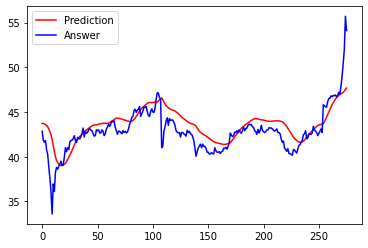

Epoch 1/50
18/18 [==============================] - 19s 526ms/step - loss: 0.0990 - accuracy: 3.4387e-04 - val_loss: 0.1808 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 7s 366ms/step - loss: 0.0228 - accuracy: 9.7005e-05 - val_loss: 0.0194 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 7s 406ms/step - loss: 0.0049 - accuracy: 3.4387e-04 - val_loss: 0.0349 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 7s 394ms/step - loss: 0.0040 - accuracy: 3.9527e-04 - val_loss: 0.0091 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 7s 399ms/step - loss: 0.0034 - accuracy: 7.0757e-04 - val_loss: 0.0202 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 8s 442ms/step - loss: 0.0037 - accuracy: 4.5401e-04 - val_loss: 0.0097 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 7s 373ms/step - loss: 0.0026 - accuracy: 1.2442

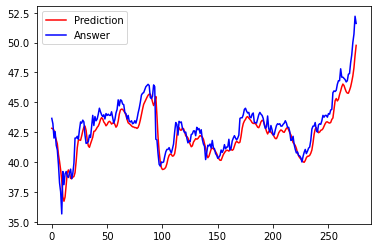

Epoch 1/50
18/18 [==============================] - 15s 456ms/step - loss: 0.3072 - accuracy: 3.9527e-04 - val_loss: 0.0753 - val_accuracy: 0.0040
Epoch 2/50
18/18 [==============================] - 7s 376ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - val_loss: 0.0571 - val_accuracy: 0.0040
Epoch 3/50
18/18 [==============================] - 8s 423ms/step - loss: 0.0181 - accuracy: 0.0000e+00 - val_loss: 0.0625 - val_accuracy: 0.0040
Epoch 4/50
18/18 [==============================] - 8s 423ms/step - loss: 0.0175 - accuracy: 0.0000e+00 - val_loss: 0.0716 - val_accuracy: 0.0040
Epoch 5/50
18/18 [==============================] - 7s 384ms/step - loss: 0.0166 - accuracy: 0.0000e+00 - val_loss: 0.0720 - val_accuracy: 0.0040
Epoch 6/50
18/18 [==============================] - 7s 370ms/step - loss: 0.0177 - accuracy: 0.0000e+00 - val_loss: 0.0817 - val_accuracy: 0.0040
Epoch 7/50
18/18 [==============================] - 7s 420ms/step - loss: 0.0183 - accuracy: 0.0000e+00 - val_loss: 0.0748 

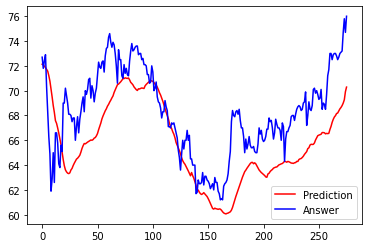

Epoch 1/50
18/18 [==============================] - 18s 539ms/step - loss: 0.1442 - accuracy: 7.1306e-05 - val_loss: 0.1416 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 7s 364ms/step - loss: 0.0429 - accuracy: 6.9643e-04 - val_loss: 0.0129 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 8s 423ms/step - loss: 0.0074 - accuracy: 0.0014 - val_loss: 0.0050 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 7s 364ms/step - loss: 0.0046 - accuracy: 9.7824e-04 - val_loss: 0.0042 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 7s 405ms/step - loss: 0.0044 - accuracy: 5.5625e-04 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 6s 353ms/step - loss: 0.0032 - accuracy: 0.0017 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 6s 361ms/step - loss: 0.0034 - accuracy: 6.7347e-04 - v

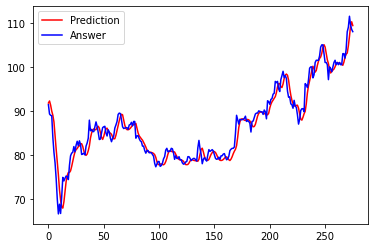

Epoch 1/50
18/18 [==============================] - 18s 545ms/step - loss: 0.1631 - accuracy: 0.0015 - val_loss: 0.0474 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 8s 443ms/step - loss: 0.0428 - accuracy: 1.5379e-04 - val_loss: 0.0223 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 6s 358ms/step - loss: 0.0381 - accuracy: 7.1306e-05 - val_loss: 0.0154 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 7s 373ms/step - loss: 0.0245 - accuracy: 8.4463e-04 - val_loss: 0.0064 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 7s 394ms/step - loss: 0.0127 - accuracy: 3.9527e-04 - val_loss: 0.0100 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 7s 392ms/step - loss: 0.0072 - accuracy: 0.0011 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 7s 400ms/step - loss: 0.0068 - accuracy: 1.5379e-04 - v

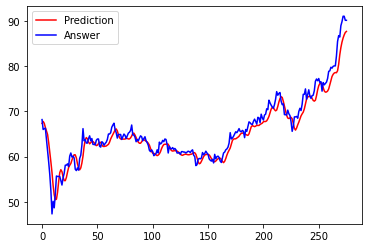

Epoch 1/50
18/18 [==============================] - 16s 487ms/step - loss: 0.1097 - accuracy: 0.0000e+00 - val_loss: 0.0213 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 7s 375ms/step - loss: 0.0124 - accuracy: 0.0015 - val_loss: 0.0034 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 7s 372ms/step - loss: 0.0030 - accuracy: 5.2254e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 6s 356ms/step - loss: 0.0027 - accuracy: 1.2442e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 7s 372ms/step - loss: 0.0027 - accuracy: 0.0011 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 7s 363ms/step - loss: 0.0025 - accuracy: 4.5401e-04 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 6s 353ms/step - loss: 0.0024 - accuracy: 6.0477e-04 - v

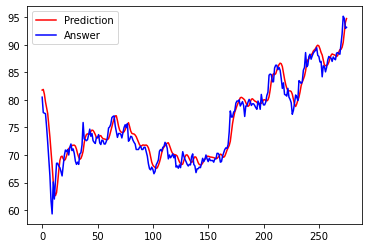

Epoch 1/50
18/18 [==============================] - 17s 534ms/step - loss: 0.1169 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 7s 397ms/step - loss: 0.0382 - accuracy: 0.0000e+00 - val_loss: 0.0038 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 6s 357ms/step - loss: 0.0163 - accuracy: 4.5401e-04 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 7s 380ms/step - loss: 0.0065 - accuracy: 1.8542e-04 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 6s 360ms/step - loss: 0.0031 - accuracy: 4.7119e-05 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 7s 384ms/step - loss: 0.0027 - accuracy: 9.7005e-05 - val_loss: 9.3850e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 7s 401ms/step - loss: 0.0024 - accuracy: 2.

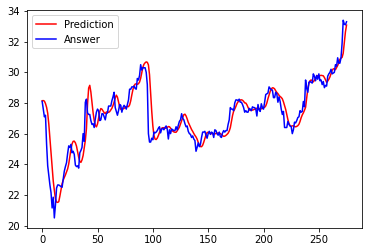

Epoch 1/50
18/18 [==============================] - 20s 592ms/step - loss: 0.1342 - accuracy: 7.1306e-05 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 8s 439ms/step - loss: 0.0305 - accuracy: 7.1306e-05 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 10s 545ms/step - loss: 0.0206 - accuracy: 3.4387e-04 - val_loss: 6.0791e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 10s 572ms/step - loss: 0.0072 - accuracy: 4.5401e-04 - val_loss: 5.0772e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 8s 417ms/step - loss: 0.0026 - accuracy: 7.1306e-05 - val_loss: 2.6641e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 7s 419ms/step - loss: 0.0022 - accuracy: 8.4463e-04 - val_loss: 2.4185e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 8s 417ms/step - loss: 0.0018 

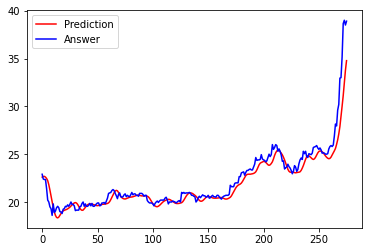

Epoch 1/50
18/18 [==============================] - 17s 450ms/step - loss: 0.2221 - accuracy: 0.0000e+00 - val_loss: 0.1281 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 7s 380ms/step - loss: 0.0316 - accuracy: 1.8542e-04 - val_loss: 0.1596 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 7s 394ms/step - loss: 0.0297 - accuracy: 0.0000e+00 - val_loss: 0.1362 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 7s 389ms/step - loss: 0.0291 - accuracy: 2.1968e-04 - val_loss: 0.1393 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 7s 384ms/step - loss: 0.0305 - accuracy: 8.4463e-04 - val_loss: 0.1280 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 7s 400ms/step - loss: 0.0293 - accuracy: 6.0477e-04 - val_loss: 0.1111 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 7s 410ms/step - loss: 0.0307 - accuracy: 0.0000

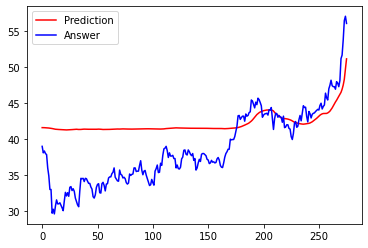

Epoch 1/50
18/18 [==============================] - 18s 473ms/step - loss: 0.0862 - accuracy: 2.5706e-04 - val_loss: 0.1364 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 8s 453ms/step - loss: 0.0117 - accuracy: 2.9818e-04 - val_loss: 0.0321 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 8s 443ms/step - loss: 0.0026 - accuracy: 5.2254e-04 - val_loss: 0.0215 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 7s 417ms/step - loss: 0.0013 - accuracy: 3.9527e-04 - val_loss: 0.0162 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 8s 426ms/step - loss: 0.0013 - accuracy: 1.5379e-04 - val_loss: 0.0124 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 8s 460ms/step - loss: 0.0011 - accuracy: 7.1306e-05 - val_loss: 0.0141 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 9s 493ms/step - loss: 9.9864e-04 - accuracy: 6.

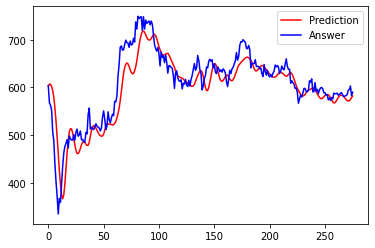

Epoch 1/50
18/18 [==============================] - 17s 504ms/step - loss: 0.1759 - accuracy: 5.2254e-04 - val_loss: 0.0246 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 7s 413ms/step - loss: 0.0444 - accuracy: 7.1306e-05 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 8s 464ms/step - loss: 0.0146 - accuracy: 7.2919e-04 - val_loss: 0.0106 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 9s 509ms/step - loss: 0.0052 - accuracy: 0.0012 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 10s 533ms/step - loss: 0.0033 - accuracy: 0.0017 - val_loss: 8.2829e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 8s 427ms/step - loss: 0.0026 - accuracy: 5.9384e-04 - val_loss: 4.7476e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 8s 438ms/step - loss: 0.0024 - accuracy: 0.001

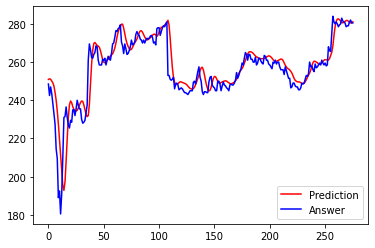

Epoch 1/50
18/18 [==============================] - 18s 509ms/step - loss: 0.0331 - accuracy: 0.0015 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 6s 349ms/step - loss: 0.0019 - accuracy: 3.9527e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 8s 442ms/step - loss: 0.0011 - accuracy: 1.2442e-04 - val_loss: 8.2951e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 8s 450ms/step - loss: 0.0011 - accuracy: 8.4463e-04 - val_loss: 8.0151e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 8s 428ms/step - loss: 0.0010 - accuracy: 2.1968e-04 - val_loss: 7.7792e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 8s 438ms/step - loss: 9.6149e-04 - accuracy: 6.0477e-04 - val_loss: 7.7244e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 8s 415ms/step - loss: 9.0487e-0

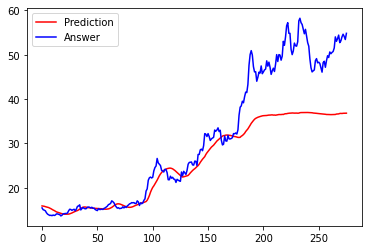

Epoch 1/50
18/18 [==============================] - 22s 613ms/step - loss: 0.0765 - accuracy: 1.8542e-04 - val_loss: 0.0092 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 8s 439ms/step - loss: 0.0171 - accuracy: 7.0757e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 8s 461ms/step - loss: 0.0025 - accuracy: 0.0011 - val_loss: 7.6693e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 8s 421ms/step - loss: 0.0015 - accuracy: 6.0477e-04 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 8s 425ms/step - loss: 0.0011 - accuracy: 1.2442e-04 - val_loss: 7.1388e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 8s 439ms/step - loss: 9.9890e-04 - accuracy: 3.4387e-04 - val_loss: 6.2384e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 8s 468ms/step - loss: 8.6450e-04 - 

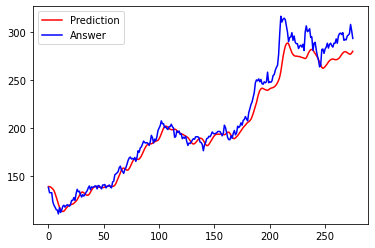

Epoch 1/50
18/18 [==============================] - 20s 583ms/step - loss: 0.2233 - accuracy: 1.5387e-04 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 7s 419ms/step - loss: 0.0144 - accuracy: 7.1391e-05 - val_loss: 0.0054 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 7s 396ms/step - loss: 0.0128 - accuracy: 2.5715e-04 - val_loss: 0.0062 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 8s 418ms/step - loss: 0.0119 - accuracy: 5.2262e-04 - val_loss: 0.0076 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 7s 397ms/step - loss: 0.0125 - accuracy: 9.7090e-05 - val_loss: 0.0054 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 7s 401ms/step - loss: 0.0111 - accuracy: 5.2262e-04 - val_loss: 0.0113 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 7s 414ms/step - loss: 0.0126 - accuracy: 5.2262

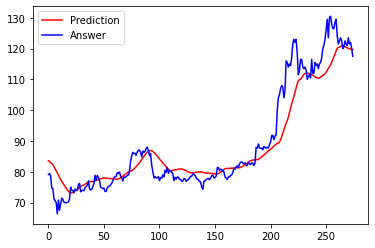

Epoch 1/50
18/18 [==============================] - 27s 784ms/step - loss: 0.0263 - accuracy: 7.0659e-04 - val_loss: 0.0066 - val_accuracy: 0.0041
Epoch 2/50
18/18 [==============================] - 9s 526ms/step - loss: 0.0040 - accuracy: 7.4033e-04 - val_loss: 0.0100 - val_accuracy: 0.0041
Epoch 3/50
18/18 [==============================] - 10s 527ms/step - loss: 0.0030 - accuracy: 0.0012 - val_loss: 0.0014 - val_accuracy: 0.0041
Epoch 4/50
18/18 [==============================] - 9s 492ms/step - loss: 0.0012 - accuracy: 0.0017 - val_loss: 0.0010 - val_accuracy: 0.0041
Epoch 5/50
18/18 [==============================] - 8s 467ms/step - loss: 0.0016 - accuracy: 0.0012 - val_loss: 0.0030 - val_accuracy: 0.0041
Epoch 6/50
18/18 [==============================] - 8s 459ms/step - loss: 0.0015 - accuracy: 0.0011 - val_loss: 7.1687e-04 - val_accuracy: 0.0041
Epoch 7/50
18/18 [==============================] - 10s 582ms/step - loss: 0.0013 - accuracy: 7.8007e-04 - val_loss: 0.0019 - val_accu

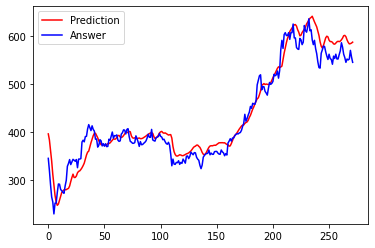

Epoch 1/50
18/18 [==============================] - 17s 522ms/step - loss: 0.0161 - accuracy: 1.8542e-04 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 8s 423ms/step - loss: 7.6441e-04 - accuracy: 6.0477e-04 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 7s 390ms/step - loss: 2.5218e-04 - accuracy: 1.8542e-04 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 7s 371ms/step - loss: 1.4786e-04 - accuracy: 5.2254e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 7s 367ms/step - loss: 1.3768e-04 - accuracy: 4.5401e-04 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 7s 382ms/step - loss: 1.5685e-04 - accuracy: 6.0477e-04 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 7s 368ms/step - loss: 1.403

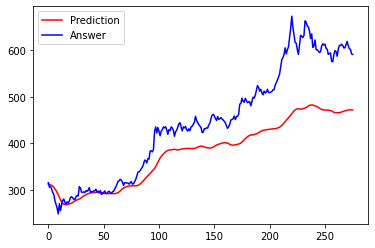

Epoch 1/50
18/18 [==============================] - 16s 444ms/step - loss: 0.0700 - accuracy: 2.9818e-04 - val_loss: 0.0509 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 6s 354ms/step - loss: 0.0153 - accuracy: 2.1968e-04 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 6s 352ms/step - loss: 0.0025 - accuracy: 0.0011 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 6s 344ms/step - loss: 0.0014 - accuracy: 7.0757e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 6s 339ms/step - loss: 0.0010 - accuracy: 0.0015 - val_loss: 8.7506e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 6s 348ms/step - loss: 0.0010 - accuracy: 4.5401e-04 - val_loss: 5.8010e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 6s 350ms/step - loss: 9.5189e-04 - accuracy: 0.

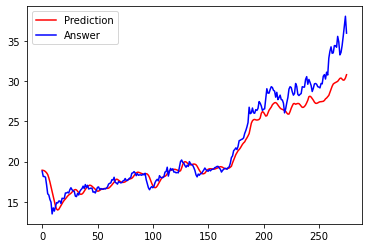

Epoch 1/50
18/18 [==============================] - 15s 438ms/step - loss: 0.3000 - accuracy: 4.5443e-04 - val_loss: 0.0681 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 6s 347ms/step - loss: 0.0278 - accuracy: 0.0000e+00 - val_loss: 0.0213 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 6s 346ms/step - loss: 0.0248 - accuracy: 0.0000e+00 - val_loss: 0.0174 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 6s 344ms/step - loss: 0.0222 - accuracy: 0.0000e+00 - val_loss: 0.0241 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 6s 341ms/step - loss: 0.0229 - accuracy: 0.0000e+00 - val_loss: 0.0260 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 6s 344ms/step - loss: 0.0228 - accuracy: 0.0000e+00 - val_loss: 0.0240 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 6s 342ms/step - loss: 0.0231 - accuracy: 0.0000

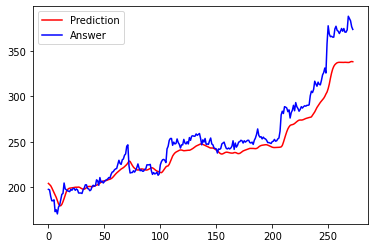

Epoch 1/50
18/18 [==============================] - 18s 603ms/step - loss: 0.0080 - accuracy: 7.1306e-05 - val_loss: 0.0307 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 7s 410ms/step - loss: 9.9337e-04 - accuracy: 6.0477e-04 - val_loss: 0.0120 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 7s 378ms/step - loss: 2.7726e-04 - accuracy: 7.0757e-04 - val_loss: 0.0101 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 6s 360ms/step - loss: 1.7538e-04 - accuracy: 9.7005e-05 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 6s 357ms/step - loss: 1.6704e-04 - accuracy: 1.8542e-04 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 7s 372ms/step - loss: 1.6731e-04 - accuracy: 2.9818e-04 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 6s 360ms/step - loss: 1.574

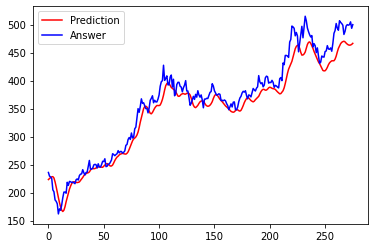

Epoch 1/50
18/18 [==============================] - 16s 483ms/step - loss: 0.0970 - accuracy: 6.0477e-04 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 7s 383ms/step - loss: 0.0190 - accuracy: 3.9527e-04 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 7s 363ms/step - loss: 0.0041 - accuracy: 1.2442e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 7s 373ms/step - loss: 0.0033 - accuracy: 4.5401e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 6s 352ms/step - loss: 0.0032 - accuracy: 3.4387e-04 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 6s 361ms/step - loss: 0.0030 - accuracy: 0.0011 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 6s 352ms/step - loss: 0.0029 - accuracy: 1.8542e-04

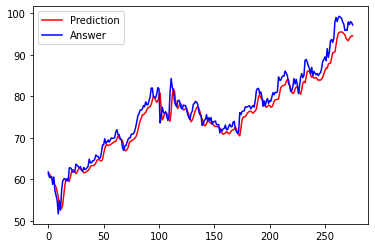

Epoch 1/50
18/18 [==============================] - 15s 436ms/step - loss: 0.1098 - accuracy: 2.9818e-04 - val_loss: 0.1197 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 6s 347ms/step - loss: 0.0162 - accuracy: 2.5706e-04 - val_loss: 0.0243 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 6s 347ms/step - loss: 0.0039 - accuracy: 1.8542e-04 - val_loss: 0.0161 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 6s 346ms/step - loss: 0.0016 - accuracy: 4.5401e-04 - val_loss: 0.0053 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 6s 344ms/step - loss: 0.0012 - accuracy: 1.5379e-04 - val_loss: 0.0051 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 6s 349ms/step - loss: 0.0011 - accuracy: 2.9818e-04 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 6s 350ms/step - loss: 8.8214e-04 - accuracy: 3.

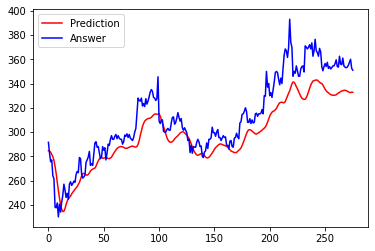

Epoch 1/50
18/18 [==============================] - 15s 430ms/step - loss: 0.1059 - accuracy: 9.4894e-04 - val_loss: 0.0083 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 6s 345ms/step - loss: 0.0093 - accuracy: 0.0017 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 6s 355ms/step - loss: 0.0043 - accuracy: 0.0018 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 6s 350ms/step - loss: 0.0025 - accuracy: 0.0011 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 6s 347ms/step - loss: 0.0025 - accuracy: 4.5227e-04 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 6s 351ms/step - loss: 0.0016 - accuracy: 4.3966e-04 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 6s 350ms/step - loss: 0.0018 - accuracy: 7.4252e-04 - val_l

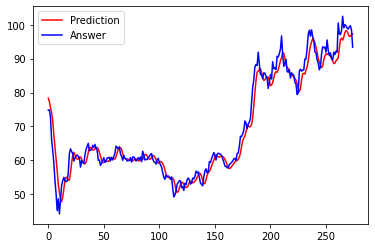

Epoch 1/50
18/18 [==============================] - 16s 528ms/step - loss: 0.2152 - accuracy: 0.0000e+00 - val_loss: 0.0934 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 7s 375ms/step - loss: 0.0362 - accuracy: 3.4429e-04 - val_loss: 0.0579 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 7s 413ms/step - loss: 0.0306 - accuracy: 3.9569e-04 - val_loss: 0.0111 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 7s 365ms/step - loss: 0.0087 - accuracy: 4.7544e-05 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 6s 347ms/step - loss: 0.0051 - accuracy: 2.5749e-04 - val_loss: 7.6822e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 6s 354ms/step - loss: 0.0027 - accuracy: 2.5749e-04 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 6s 353ms/step - loss: 0.0025 - accuracy: 2.

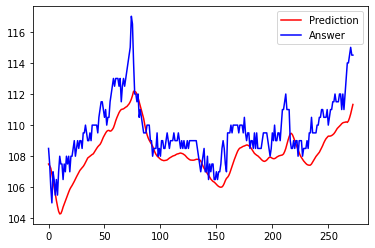

Epoch 1/50
18/18 [==============================] - 17s 490ms/step - loss: 0.0678 - accuracy: 9.7005e-05 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 7s 377ms/step - loss: 0.0089 - accuracy: 2.9818e-04 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 7s 400ms/step - loss: 0.0066 - accuracy: 6.0477e-04 - val_loss: 5.3885e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 7s 372ms/step - loss: 0.0013 - accuracy: 5.2254e-04 - val_loss: 3.9713e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 9s 495ms/step - loss: 0.0011 - accuracy: 2.1968e-04 - val_loss: 5.3578e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 9s 511ms/step - loss: 8.8603e-04 - accuracy: 2.9818e-04 - val_loss: 4.2296e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 9s 492ms/step - loss: 8.434

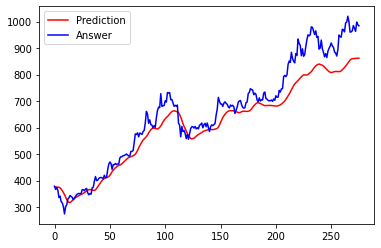

Epoch 1/50
18/18 [==============================] - 17s 486ms/step - loss: 0.2607 - accuracy: 9.7005e-05 - val_loss: 0.0124 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 7s 376ms/step - loss: 0.0551 - accuracy: 2.1968e-04 - val_loss: 0.0054 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 7s 374ms/step - loss: 0.0518 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 7s 386ms/step - loss: 0.0407 - accuracy: 0.0015 - val_loss: 0.0265 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 7s 394ms/step - loss: 0.0200 - accuracy: 1.5379e-04 - val_loss: 0.0048 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 7s 392ms/step - loss: 0.0072 - accuracy: 9.7005e-05 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 7s 385ms/step - loss: 0.0042 - accuracy: 4.7119e-05

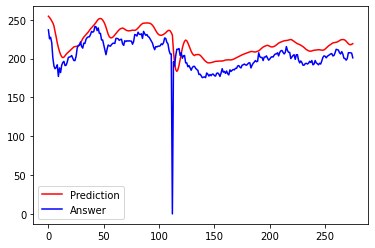

Epoch 1/50
18/18 [==============================] - 19s 537ms/step - loss: 0.0193 - accuracy: 7.0772e-04 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 8s 460ms/step - loss: 0.0029 - accuracy: 4.7267e-05 - val_loss: 4.5668e-05 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 8s 463ms/step - loss: 5.3985e-04 - accuracy: 5.2269e-04 - val_loss: 2.5124e-05 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 8s 466ms/step - loss: 4.1102e-04 - accuracy: 6.0492e-04 - val_loss: 2.5565e-05 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 9s 517ms/step - loss: 3.6843e-04 - accuracy: 5.2269e-04 - val_loss: 3.9987e-05 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 10s 530ms/step - loss: 3.8453e-04 - accuracy: 5.2269e-04 - val_loss: 2.7026e-05 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 9s 475ms/s

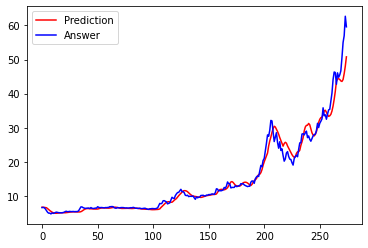

Epoch 1/50
18/18 [==============================] - 25s 832ms/step - loss: 0.1019 - accuracy: 0.0000e+00 - val_loss: 0.0094 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 10s 578ms/step - loss: 0.0332 - accuracy: 0.0000e+00 - val_loss: 0.0187 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 11s 591ms/step - loss: 0.0166 - accuracy: 1.8542e-04 - val_loss: 0.0072 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 10s 562ms/step - loss: 0.0066 - accuracy: 2.1968e-04 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 10s 561ms/step - loss: 0.0036 - accuracy: 2.5706e-04 - val_loss: 6.3172e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 10s 552ms/step - loss: 0.0025 - accuracy: 2.1968e-04 - val_loss: 6.2954e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 10s 575ms/step - loss: 0.0021 - ac

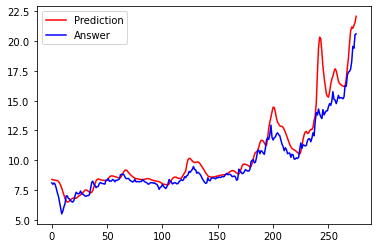

Epoch 1/50
7/7 [==============================] - 15s 908ms/step - loss: 0.1833 - accuracy: 8.8924e-04 - val_loss: 0.0241 - val_accuracy: 0.0000e+00
Epoch 2/50
7/7 [==============================] - 4s 636ms/step - loss: 0.0566 - accuracy: 4.4979e-04 - val_loss: 0.0185 - val_accuracy: 0.0000e+00
Epoch 3/50
7/7 [==============================] - 4s 492ms/step - loss: 0.0482 - accuracy: 4.4979e-04 - val_loss: 0.0115 - val_accuracy: 0.0000e+00
Epoch 4/50
7/7 [==============================] - 3s 479ms/step - loss: 0.0223 - accuracy: 0.0039 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 5/50
7/7 [==============================] - 3s 499ms/step - loss: 0.0101 - accuracy: 0.0012 - val_loss: 0.0105 - val_accuracy: 0.0000e+00
Epoch 6/50
7/7 [==============================] - 4s 556ms/step - loss: 0.0075 - accuracy: 0.0036 - val_loss: 0.0182 - val_accuracy: 0.0000e+00
Epoch 7/50
7/7 [==============================] - 4s 661ms/step - loss: 0.0076 - accuracy: 0.0013 - val_loss: 0.0054 - val_

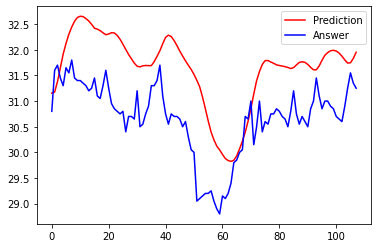

Epoch 1/50
18/18 [==============================] - 23s 621ms/step - loss: 0.1027 - accuracy: 2.7820e-04 - val_loss: 0.1012 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 9s 508ms/step - loss: 0.0287 - accuracy: 3.5407e-04 - val_loss: 0.0644 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 12s 679ms/step - loss: 0.0162 - accuracy: 0.0020 - val_loss: 0.0268 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 13s 715ms/step - loss: 0.0098 - accuracy: 6.3053e-04 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 8s 461ms/step - loss: 0.0037 - accuracy: 8.1605e-04 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 8s 448ms/step - loss: 0.0030 - accuracy: 9.4628e-04 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 9s 528ms/step - loss: 0.0028 - accuracy: 0.0030 -

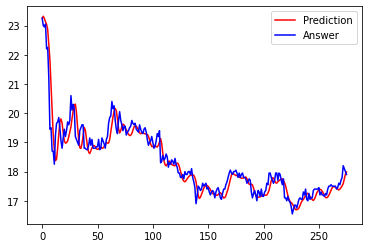

Epoch 1/50
18/18 [==============================] - 25s 835ms/step - loss: 0.0924 - accuracy: 0.0011 - val_loss: 0.1213 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 10s 555ms/step - loss: 0.0207 - accuracy: 4.6852e-04 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 10s 521ms/step - loss: 0.0046 - accuracy: 0.0015 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 13s 696ms/step - loss: 0.0033 - accuracy: 0.0020 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 9s 514ms/step - loss: 0.0027 - accuracy: 8.7911e-04 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 10s 571ms/step - loss: 0.0029 - accuracy: 0.0012 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 11s 634ms/step - loss: 0.0024 - accuracy: 0.0015 - val_loss

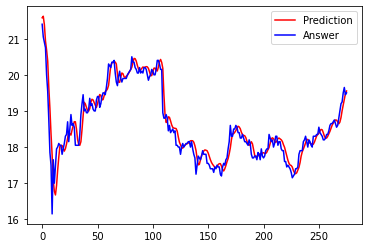

Epoch 1/50
18/18 [==============================] - 23s 717ms/step - loss: 0.1248 - accuracy: 7.0757e-04 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 9s 510ms/step - loss: 0.0339 - accuracy: 4.5401e-04 - val_loss: 7.2679e-04 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 9s 522ms/step - loss: 0.0111 - accuracy: 4.9227e-04 - val_loss: 0.0119 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 9s 506ms/step - loss: 0.0060 - accuracy: 0.0011 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 10s 570ms/step - loss: 0.0034 - accuracy: 6.9345e-04 - val_loss: 5.8409e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 10s 570ms/step - loss: 0.0026 - accuracy: 0.0022 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 9s 517ms/step - loss: 0.0028 - accuracy: 7.42

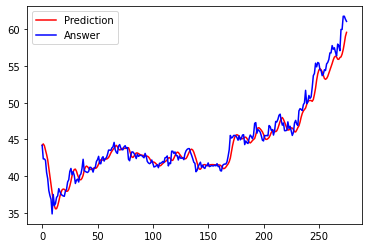

Epoch 1/50
18/18 [==============================] - 22s 693ms/step - loss: 0.2001 - accuracy: 5.6966e-04 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 10s 559ms/step - loss: 0.0392 - accuracy: 3.7083e-04 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 10s 542ms/step - loss: 0.0076 - accuracy: 1.9572e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 11s 594ms/step - loss: 0.0048 - accuracy: 0.0020 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 10s 545ms/step - loss: 0.0040 - accuracy: 7.0178e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 11s 612ms/step - loss: 0.0037 - accuracy: 8.2072e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 11s 625ms/step - loss: 0.0032 - accuracy: 8.31

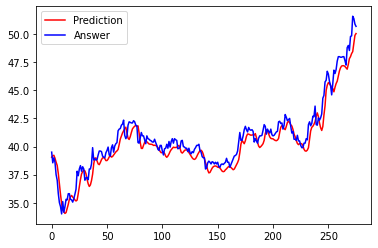

Epoch 1/50
18/18 [==============================] - 22s 610ms/step - loss: 0.1305 - accuracy: 9.7005e-05 - val_loss: 0.0125 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 8s 468ms/step - loss: 0.0363 - accuracy: 6.0477e-04 - val_loss: 0.0048 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 9s 472ms/step - loss: 0.0307 - accuracy: 4.7119e-05 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 9s 514ms/step - loss: 0.0150 - accuracy: 2.1968e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 9s 494ms/step - loss: 0.0080 - accuracy: 0.0013 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 9s 502ms/step - loss: 0.0060 - accuracy: 5.6355e-04 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 9s 519ms/step - loss: 0.0049 - accuracy: 7.4222e-04

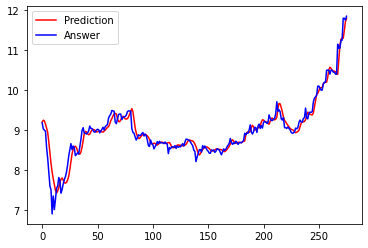

Epoch 1/50
18/18 [==============================] - 23s 691ms/step - loss: 0.0949 - accuracy: 3.9527e-04 - val_loss: 0.2407 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 9s 491ms/step - loss: 0.0150 - accuracy: 5.2254e-04 - val_loss: 0.1799 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 10s 533ms/step - loss: 0.0091 - accuracy: 8.4463e-04 - val_loss: 0.0860 - val_accuracy: 0.0040
Epoch 4/50
18/18 [==============================] - 10s 535ms/step - loss: 0.0030 - accuracy: 2.5706e-04 - val_loss: 0.0912 - val_accuracy: 0.0040
Epoch 5/50
18/18 [==============================] - 10s 555ms/step - loss: 0.0024 - accuracy: 4.7119e-05 - val_loss: 0.0656 - val_accuracy: 0.0040
Epoch 6/50
18/18 [==============================] - 9s 511ms/step - loss: 0.0020 - accuracy: 7.0757e-04 - val_loss: 0.0496 - val_accuracy: 0.0040
Epoch 7/50
18/18 [==============================] - 9s 499ms/step - loss: 0.0019 - accuracy: 1.5379e-04 - val_lo

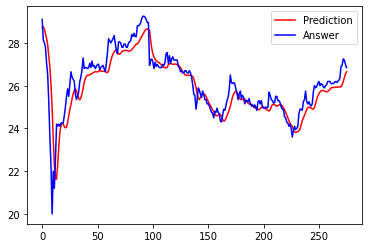

Epoch 1/50
18/18 [==============================] - 22s 670ms/step - loss: 0.0865 - accuracy: 0.0015 - val_loss: 0.0568 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 10s 578ms/step - loss: 0.0133 - accuracy: 0.0011 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 11s 629ms/step - loss: 0.0036 - accuracy: 2.9818e-04 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 10s 543ms/step - loss: 0.0023 - accuracy: 3.4387e-04 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 10s 548ms/step - loss: 0.0018 - accuracy: 1.8542e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 11s 617ms/step - loss: 0.0017 - accuracy: 0.0011 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 9s 509ms/step - loss: 0.0017 - accuracy: 3.9527e-04 - 

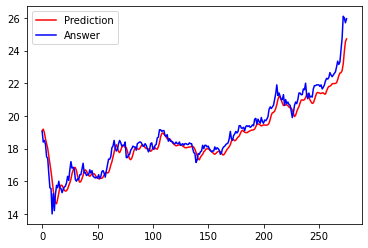

Epoch 1/50
18/18 [==============================] - 23s 744ms/step - loss: 0.1370 - accuracy: 9.1780e-04 - val_loss: 0.1590 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 10s 570ms/step - loss: 0.0196 - accuracy: 0.0030 - val_loss: 0.1537 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 13s 732ms/step - loss: 0.0188 - accuracy: 4.7849e-04 - val_loss: 0.1331 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 8s 468ms/step - loss: 0.0184 - accuracy: 0.0012 - val_loss: 0.1499 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 9s 531ms/step - loss: 0.0178 - accuracy: 6.5199e-04 - val_loss: 0.1427 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 9s 516ms/step - loss: 0.0167 - accuracy: 7.3447e-04 - val_loss: 0.1281 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 10s 533ms/step - loss: 0.0127 - accuracy: 0.0012 - va

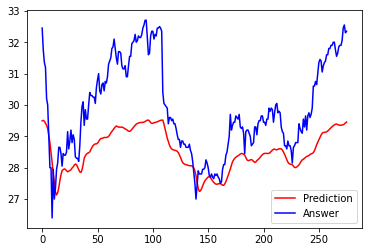

Epoch 1/50
18/18 [==============================] - 24s 745ms/step - loss: 0.1623 - accuracy: 0.0000e+00 - val_loss: 0.0325 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 10s 556ms/step - loss: 0.0334 - accuracy: 0.0011 - val_loss: 0.0193 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 10s 529ms/step - loss: 0.0262 - accuracy: 7.9091e-04 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 10s 534ms/step - loss: 0.0108 - accuracy: 4.1556e-04 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 10s 555ms/step - loss: 0.0070 - accuracy: 7.5894e-04 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 10s 592ms/step - loss: 0.0055 - accuracy: 0.0011 - val_loss: 9.5564e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 9s 526ms/step - loss: 0.0046 - accuracy: 0.001

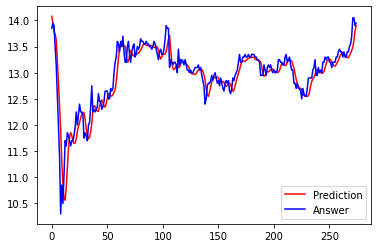

Epoch 1/50
18/18 [==============================] - 22s 654ms/step - loss: 0.1955 - accuracy: 8.4463e-04 - val_loss: 0.0445 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 9s 499ms/step - loss: 0.0474 - accuracy: 9.7005e-05 - val_loss: 0.0104 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 9s 495ms/step - loss: 0.0092 - accuracy: 4.0510e-04 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 9s 500ms/step - loss: 0.0052 - accuracy: 3.8148e-04 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 10s 538ms/step - loss: 0.0043 - accuracy: 6.4696e-04 - val_loss: 9.6763e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 9s 513ms/step - loss: 0.0042 - accuracy: 0.0023 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 9s 476ms/step - loss: 0.0039 - accuracy: 7.391

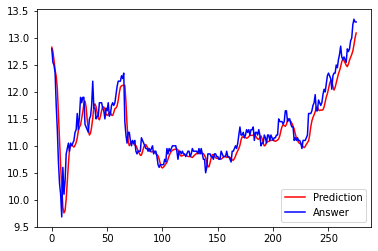

Epoch 1/50
18/18 [==============================] - 24s 717ms/step - loss: 0.1360 - accuracy: 2.9818e-04 - val_loss: 0.0389 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 9s 488ms/step - loss: 0.0341 - accuracy: 8.4463e-04 - val_loss: 0.0291 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 8s 460ms/step - loss: 0.0295 - accuracy: 9.7005e-05 - val_loss: 0.0190 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 10s 572ms/step - loss: 0.0168 - accuracy: 3.8148e-04 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 9s 508ms/step - loss: 0.0079 - accuracy: 0.0029 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 9s 474ms/step - loss: 0.0069 - accuracy: 8.6136e-04 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 13s 726ms/step - loss: 0.0057 - accuracy: 7.0178e-

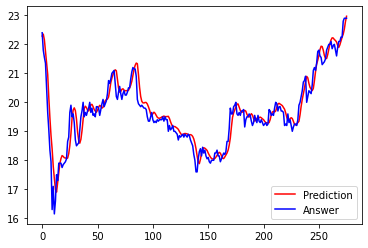

Epoch 1/50
18/18 [==============================] - 27s 849ms/step - loss: 0.1073 - accuracy: 4.5401e-04 - val_loss: 0.1219 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 10s 545ms/step - loss: 0.0308 - accuracy: 0.0015 - val_loss: 0.0164 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 13s 710ms/step - loss: 0.0075 - accuracy: 0.0013 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 12s 639ms/step - loss: 0.0040 - accuracy: 0.0011 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 9s 502ms/step - loss: 0.0031 - accuracy: 0.0019 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 11s 625ms/step - loss: 0.0029 - accuracy: 8.0568e-04 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 16s 865ms/step - loss: 0.0028 - accuracy: 0.0017 - val_loss

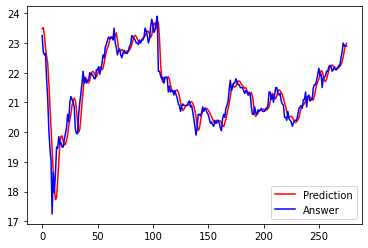

Epoch 1/50
18/18 [==============================] - 21s 585ms/step - loss: 0.2261 - accuracy: 4.8360e-04 - val_loss: 0.0707 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 9s 477ms/step - loss: 0.0300 - accuracy: 5.2254e-04 - val_loss: 0.0476 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 10s 542ms/step - loss: 0.0280 - accuracy: 4.7119e-05 - val_loss: 0.0572 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 9s 473ms/step - loss: 0.0296 - accuracy: 9.7005e-05 - val_loss: 0.0600 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 9s 478ms/step - loss: 0.0291 - accuracy: 2.9818e-04 - val_loss: 0.0609 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 9s 491ms/step - loss: 0.0299 - accuracy: 1.2442e-04 - val_loss: 0.0572 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 11s 626ms/step - loss: 0.0286 - accuracy: 6.04

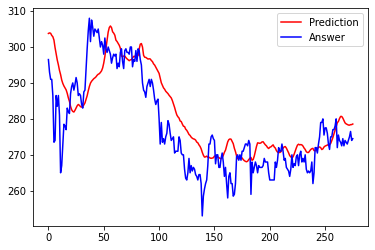

Epoch 1/50
18/18 [==============================] - 22s 623ms/step - loss: 0.1159 - accuracy: 0.0000e+00 - val_loss: 0.0056 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 10s 548ms/step - loss: 0.0099 - accuracy: 0.0017 - val_loss: 0.0104 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 9s 486ms/step - loss: 0.0035 - accuracy: 0.0022 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 9s 477ms/step - loss: 0.0019 - accuracy: 0.0010 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 8s 454ms/step - loss: 0.0014 - accuracy: 0.0016 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 9s 477ms/step - loss: 0.0015 - accuracy: 6.4205e-04 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 9s 477ms/step - loss: 0.0012 - accuracy: 0.0011 - val_loss: 0.

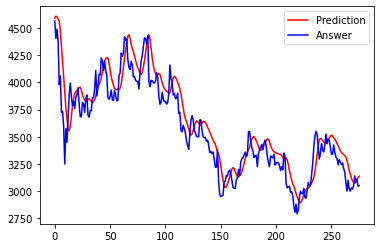

Epoch 1/50
18/18 [==============================] - 20s 598ms/step - loss: 0.0077 - accuracy: 0.0015 - val_loss: 0.0072 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 9s 479ms/step - loss: 9.7456e-04 - accuracy: 3.4387e-04 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 9s 478ms/step - loss: 2.4018e-04 - accuracy: 1.5379e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 9s 483ms/step - loss: 1.6391e-04 - accuracy: 1.8542e-04 - val_loss: 8.7082e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 9s 478ms/step - loss: 1.4212e-04 - accuracy: 3.9527e-04 - val_loss: 8.3319e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 9s 474ms/step - loss: 1.3622e-04 - accuracy: 9.7005e-05 - val_loss: 4.9737e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 10s 559ms/step - lo

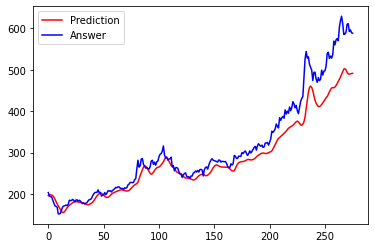

Epoch 1/50
18/18 [==============================] - 21s 650ms/step - loss: 0.2678 - accuracy: 0.0000e+00 - val_loss: 0.1139 - val_accuracy: 0.0323
Epoch 2/50
18/18 [==============================] - 9s 525ms/step - loss: 0.0545 - accuracy: 0.0017 - val_loss: 0.0063 - val_accuracy: 0.0323
Epoch 3/50
18/18 [==============================] - 9s 492ms/step - loss: 0.0091 - accuracy: 3.7385e-04 - val_loss: 0.0093 - val_accuracy: 0.0323
Epoch 4/50
18/18 [==============================] - 10s 533ms/step - loss: 0.0056 - accuracy: 6.0131e-04 - val_loss: 0.0057 - val_accuracy: 0.0323
Epoch 5/50
18/18 [==============================] - 13s 731ms/step - loss: 0.0044 - accuracy: 9.9880e-04 - val_loss: 0.0049 - val_accuracy: 0.0323
Epoch 6/50
18/18 [==============================] - 12s 654ms/step - loss: 0.0042 - accuracy: 0.0016 - val_loss: 0.0040 - val_accuracy: 0.0323
Epoch 7/50
18/18 [==============================] - 10s 550ms/step - loss: 0.0037 - accuracy: 0.0014 - val_loss: 0.0030 - val_ac

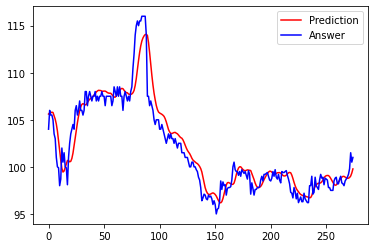

Epoch 1/50
5/5 [==============================] - 18s 1s/step - loss: 0.0809 - accuracy: 0.0013 - val_loss: 0.0733 - val_accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 3s 639ms/step - loss: 0.0375 - accuracy: 5.8173e-04 - val_loss: 0.0147 - val_accuracy: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 3s 626ms/step - loss: 0.0170 - accuracy: 0.0033 - val_loss: 0.0155 - val_accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 3s 583ms/step - loss: 0.0129 - accuracy: 9.0725e-04 - val_loss: 0.0179 - val_accuracy: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 3s 611ms/step - loss: 0.0123 - accuracy: 0.0033 - val_loss: 0.0118 - val_accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 3s 589ms/step - loss: 0.0115 - accuracy: 0.0020 - val_loss: 0.0114 - val_accuracy: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 3s 561ms/step - loss: 0.0120 - accuracy: 0.0013 - val_loss: 0.0135 - val_accurac

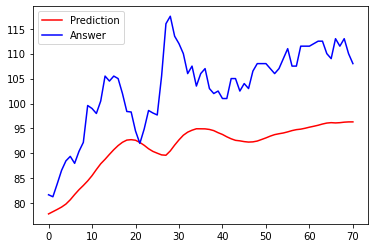

Epoch 1/50
18/18 [==============================] - 23s 684ms/step - loss: 0.3295 - accuracy: 4.5401e-04 - val_loss: 0.0141 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 10s 544ms/step - loss: 0.0715 - accuracy: 0.0011 - val_loss: 0.0279 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 12s 656ms/step - loss: 0.0648 - accuracy: 2.9818e-04 - val_loss: 0.0166 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 11s 604ms/step - loss: 0.0137 - accuracy: 3.4530e-04 - val_loss: 0.0100 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 11s 622ms/step - loss: 0.0080 - accuracy: 0.0011 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 10s 551ms/step - loss: 0.0054 - accuracy: 0.0015 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 10s 541ms/step - loss: 0.0046 - accuracy: 9.9842e-04 -

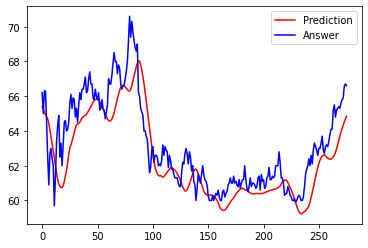

Epoch 1/50
17/17 [==============================] - 24s 803ms/step - loss: 0.2426 - accuracy: 0.0000e+00 - val_loss: 0.0136 - val_accuracy: 0.0000e+00
Epoch 2/50
17/17 [==============================] - 10s 582ms/step - loss: 0.0493 - accuracy: 2.9135e-04 - val_loss: 0.0050 - val_accuracy: 0.0000e+00
Epoch 3/50
17/17 [==============================] - 11s 648ms/step - loss: 0.0418 - accuracy: 3.3958e-04 - val_loss: 0.0051 - val_accuracy: 0.0000e+00
Epoch 4/50
17/17 [==============================] - 10s 585ms/step - loss: 0.0422 - accuracy: 5.1873e-05 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 5/50
17/17 [==============================] - 8s 476ms/step - loss: 0.0344 - accuracy: 2.9135e-04 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 6/50
17/17 [==============================] - 9s 506ms/step - loss: 0.0143 - accuracy: 0.0011 - val_loss: 0.0074 - val_accuracy: 0.0000e+00
Epoch 7/50
17/17 [==============================] - 10s 569ms/step - loss: 0.0070 - accuracy: 0.0015

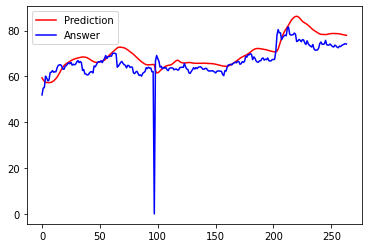

Epoch 1/50
15/15 [==============================] - 17s 602ms/step - loss: 0.0575 - accuracy: 0.0000e+00 - val_loss: 0.0897 - val_accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 7s 484ms/step - loss: 0.0093 - accuracy: 0.0000e+00 - val_loss: 0.0560 - val_accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 7s 464ms/step - loss: 0.0044 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 7s 469ms/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 7s 472ms/step - loss: 9.0000e-04 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 7s 477ms/step - loss: 7.1992e-04 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 8s 571ms/step - loss: 7.6284e-04 - accu

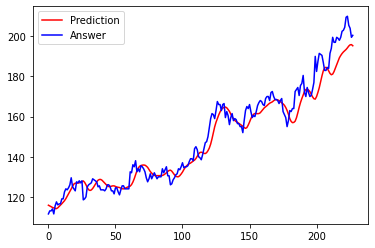

Epoch 1/50
4/4 [==============================] - 23s 2s/step - loss: 0.3200 - accuracy: 8.4034e-04 - val_loss: 0.0336 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 2s 469ms/step - loss: 0.1744 - accuracy: 0.0014 - val_loss: 0.0673 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 3s 783ms/step - loss: 0.0657 - accuracy: 0.0014 - val_loss: 0.1766 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 4s 962ms/step - loss: 0.0683 - accuracy: 0.0014 - val_loss: 0.0590 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 2s 561ms/step - loss: 0.0637 - accuracy: 0.0037 - val_loss: 0.0440 - val_accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 3s 679ms/step - loss: 0.0656 - accuracy: 0.0021 - val_loss: 0.0725 - val_accuracy: 0.0000e+00
Epoch 7/50
4/4 [==============================] - 2s 551ms/step - loss: 0.0592 - accuracy: 0.0021 - val_loss: 0.1131 - val_accuracy: 0

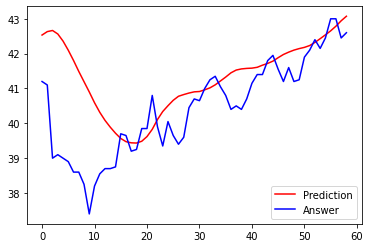

Epoch 1/50
15/15 [==============================] - 20s 667ms/step - loss: 0.1159 - accuracy: 1.8070e-04 - val_loss: 0.2446 - val_accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 7s 478ms/step - loss: 0.0304 - accuracy: 1.0244e-04 - val_loss: 0.1382 - val_accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 7s 500ms/step - loss: 0.0163 - accuracy: 9.2282e-04 - val_loss: 0.0488 - val_accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 8s 516ms/step - loss: 0.0074 - accuracy: 1.4000e-04 - val_loss: 0.0450 - val_accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 8s 512ms/step - loss: 0.0043 - accuracy: 6.3799e-04 - val_loss: 0.0161 - val_accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 9s 563ms/step - loss: 0.0028 - accuracy: 1.8070e-04 - val_loss: 0.0089 - val_accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 10s 639ms/step - loss: 0.0021 - accuracy: 4.589

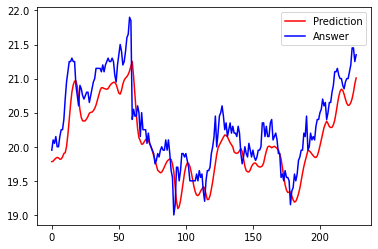

Epoch 1/50
12/12 [==============================] - 18s 669ms/step - loss: 0.0101 - accuracy: 5.4947e-04 - val_loss: 0.0633 - val_accuracy: 0.0000e+00
Epoch 2/50
12/12 [==============================] - 6s 533ms/step - loss: 0.0017 - accuracy: 0.0010 - val_loss: 0.0433 - val_accuracy: 0.0000e+00
Epoch 3/50
12/12 [==============================] - 8s 657ms/step - loss: 5.8776e-04 - accuracy: 8.1990e-04 - val_loss: 0.0198 - val_accuracy: 0.0000e+00
Epoch 4/50
12/12 [==============================] - 8s 668ms/step - loss: 2.5942e-04 - accuracy: 6.6966e-04 - val_loss: 0.0185 - val_accuracy: 0.0000e+00
Epoch 5/50
12/12 [==============================] - 8s 698ms/step - loss: 1.6489e-04 - accuracy: 6.6966e-04 - val_loss: 0.0156 - val_accuracy: 0.0000e+00
Epoch 6/50
12/12 [==============================] - 8s 625ms/step - loss: 1.7534e-04 - accuracy: 0.0019 - val_loss: 0.0120 - val_accuracy: 0.0000e+00
Epoch 7/50
12/12 [==============================] - 6s 530ms/step - loss: 1.5974e-04 - accu

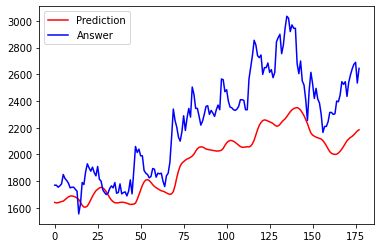

Epoch 1/50
18/18 [==============================] - 24s 730ms/step - loss: 0.0865 - accuracy: 3.9527e-04 - val_loss: 0.0371 - val_accuracy: 0.0000e+00
Epoch 2/50
18/18 [==============================] - 10s 546ms/step - loss: 0.0135 - accuracy: 7.1107e-04 - val_loss: 0.0053 - val_accuracy: 0.0000e+00
Epoch 3/50
18/18 [==============================] - 11s 617ms/step - loss: 0.0026 - accuracy: 0.0011 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 4/50
18/18 [==============================] - 10s 566ms/step - loss: 0.0022 - accuracy: 0.0014 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 5/50
18/18 [==============================] - 9s 505ms/step - loss: 0.0020 - accuracy: 3.4410e-04 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 6/50
18/18 [==============================] - 9s 477ms/step - loss: 0.0019 - accuracy: 0.0011 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 7/50
18/18 [==============================] - 9s 520ms/step - loss: 0.0020 - accuracy: 7.0178e-04 - va

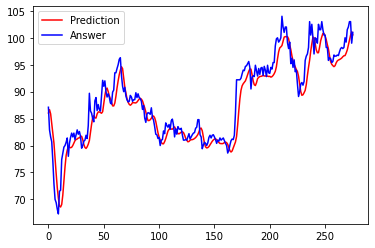

Epoch 1/50
4/4 [==============================] - 18s 2s/step - loss: 0.3434 - accuracy: 0.0015 - val_loss: 0.4487 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 2s 488ms/step - loss: 0.2398 - accuracy: 0.0039 - val_loss: 0.1265 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 2s 477ms/step - loss: 0.0760 - accuracy: 0.0039 - val_loss: 0.0117 - val_accuracy: 0.0227
Epoch 4/50
4/4 [==============================] - 2s 455ms/step - loss: 0.1066 - accuracy: 0.0000e+00 - val_loss: 0.0315 - val_accuracy: 0.0227
Epoch 5/50
4/4 [==============================] - 2s 519ms/step - loss: 0.0616 - accuracy: 0.0023 - val_loss: 0.0892 - val_accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 2s 638ms/step - loss: 0.0743 - accuracy: 0.0015 - val_loss: 0.0554 - val_accuracy: 0.0227
Epoch 7/50
4/4 [==============================] - 2s 572ms/step - loss: 0.0409 - accuracy: 0.0039 - val_loss: 0.0144 - val_accuracy: 0.0227
Epoch 

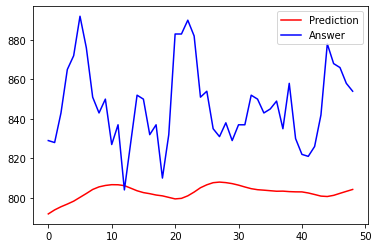

Epoch 1/50
18/18 [==============================] - 32s 1s/step - loss: 0.0967 - accuracy: 0.0015 - val_loss: 0.0508 - val_accuracy: 0.0040
Epoch 2/50
18/18 [==============================] - 18s 999ms/step - loss: 0.0059 - accuracy: 3.4387e-04 - val_loss: 0.0370 - val_accuracy: 0.0040
Epoch 3/50
18/18 [==============================] - 13s 655ms/step - loss: 0.0023 - accuracy: 0.0011 - val_loss: 0.0115 - val_accuracy: 0.0040
Epoch 4/50
18/18 [==============================] - 13s 710ms/step - loss: 0.0013 - accuracy: 6.0477e-04 - val_loss: 0.0055 - val_accuracy: 0.0040
Epoch 5/50
18/18 [==============================] - 10s 553ms/step - loss: 0.0011 - accuracy: 1.8542e-04 - val_loss: 0.0034 - val_accuracy: 0.0040
Epoch 6/50
18/18 [==============================] - 10s 524ms/step - loss: 0.0011 - accuracy: 2.5706e-04 - val_loss: 0.0036 - val_accuracy: 0.0040
Epoch 7/50
18/18 [==============================] - 9s 476ms/step - loss: 0.0011 - accuracy: 9.7005e-05 - val_loss: 0.0059 - val_

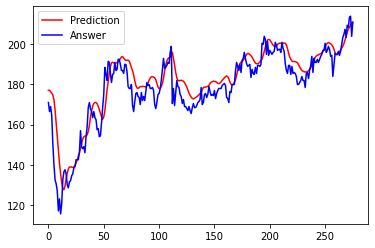

In [18]:
import csv
with open('stock_list.csv',encoding="utf-8") as f:
    list_of_stock = csv.DictReader(f)
    for obj in list_of_stock:
        stock_pred(obj['stock_id'])